# Nonlinear Static Estimation
Investigates the nonlinear estimation problem for a ship lost at sea given ranging from a group of beacons on the shore (located at $x=0$) 


In [8]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la


Running Python: 3.8.16


In [53]:
#actual (unknown) solution
x0 = np.vstack(np.array([[-3], [0]])) 
# initial uncertainty in location
Q0 = np.matrix([[0.3**2, 0], [0, 0.3**2]]) # initial state uncertainty

In [73]:
# for plotting an uncertainty ellipse
def plot_ellipse(xe,QI): # for showing the progress
    t_max = 100
    t = np.linspace(0, 2*np.pi, t_max)
    a = QI[0,0]
    b = QI[0,1]
    c = QI[1,1]
    lam1 = np.sqrt((a+c)/2+np.sqrt(((a-c)/2)**2+b**2))
    lam2 = np.sqrt((a+c)/2-np.sqrt(((a-c)/2)**2+b**2))

    if ((b==0) & (a >= c)):
        phi = 0
    elif ((b == 0) & (a < c)):
        phi = np.pi/2
    else:
        phi = np.arctan2(lam1**2-a,b)

    Ellipse_xh = np.zeros((t_max,2))
    Ellipse_xh[:,0] = np.ones((1,t_max))*xe[0,0]+lam1*np.cos(t)*np.cos(phi)-lam2*np.sin(t)*np.sin(phi)
    Ellipse_xh[:,1] = np.ones((1,t_max))*xe[1,0]+lam1*np.cos(t)*np.sin(phi)+lam2*np.sin(t)*np.cos(phi)
    return Ellipse_xh

sig = 0.1**2
H0 = np.array([[1,0],[0,-1]]); R0 = np.diag([sig,sig])
H1 = np.array([1,0]).reshape(1,2)
H2 = np.array([0,-1]).reshape(1,2)
H3 = np.array([1,1]).reshape(1,2)
H4 = np.array([1,-1]).reshape(1,2)

Qp0 = np.linalg.inv(np.linalg.inv(Q0) + H0.T@np.linalg.inv(R0)@H0)
Qp1 = np.linalg.inv(np.linalg.inv(Q0) + H1.T@H1/sig)
Qp2 = np.linalg.inv(np.linalg.inv(Q0) + H2.T@H2/sig)
Qp3 = np.linalg.inv(np.linalg.inv(Q0) + H3.T@H3/sig)
Qp4 = np.linalg.inv(np.linalg.inv(Q0) + H4.T@H4/sig)

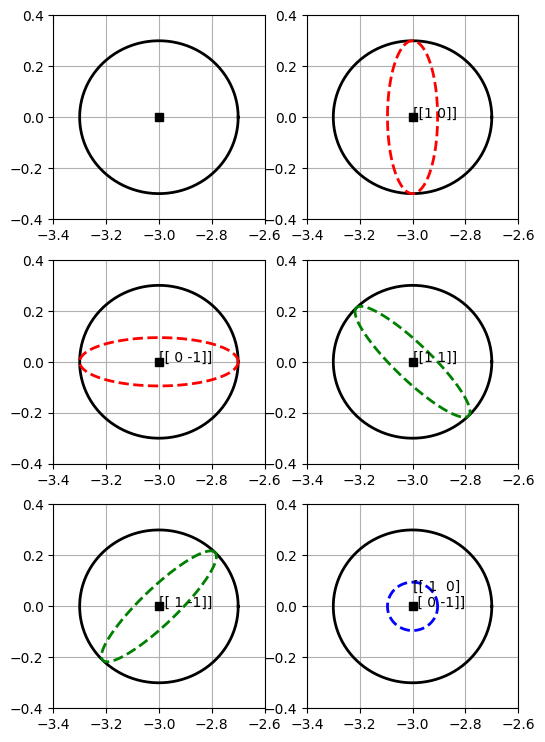

In [83]:
Ellipse_x0 = plot_ellipse(x0,Q0)
Ellipse_xp0 = plot_ellipse(x0,Qp0)
Ellipse_xp1 = plot_ellipse(x0,Qp1)
Ellipse_xp2 = plot_ellipse(x0,Qp2)
Ellipse_xp3 = plot_ellipse(x0,Qp3)
Ellipse_xp4 = plot_ellipse(x0,Qp4)

fig, ax = plt.subplots(3, 2, figsize=(6,9))
for ii in range(3):
    for jj in range(2):
        ax[ii,jj].plot(Ellipse_x0[:,0],Ellipse_x0[:,1],'k-')
        ax[ii,jj].plot(x0[0,0],x0[1,0],'ks',label=r'$\hat x^-$')
        ax[ii,jj].set_xlim([-3.4,-2.6])
        ax[ii,jj].set_ylim([-.4,.4])
ax[2,1].plot(Ellipse_xp0[:,0],Ellipse_xp0[:,1],'b--')
ax[2,1].text(-3,0,H0)
ax[0,1].plot(Ellipse_xp1[:,0],Ellipse_xp1[:,1],'r--')
ax[0,1].text(-3,0,H1)
ax[1,0].plot(Ellipse_xp2[:,0],Ellipse_xp2[:,1],'r--')
ax[1,0].text(-3,0,H2)
ax[1,1].plot(Ellipse_xp3[:,0],Ellipse_xp3[:,1],'g--')
ax[1,1].text(-3,0,H3)
ax[2,0].plot(Ellipse_xp4[:,0],Ellipse_xp4[:,1],'g--')
ax[2,0].text(-3,0,H4)
plt.show()


Measurement $H=[1,1]$ with noise $\sigma < 1$ gives us accurate information about the signal $x_1+x_2$, which is a 45 deg rotation (to the left) of the $x_1$ axis.  

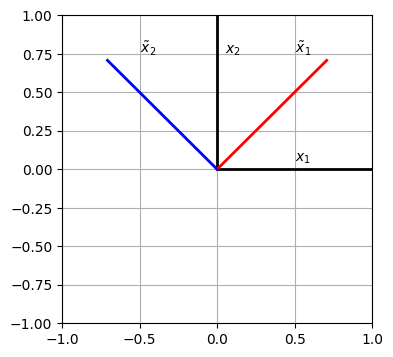

In [105]:
alp = 45/57.3
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0,1],[0,0],'k-')
ax.plot([0,0],[0,1],'k-')
ax.plot([0,np.cos(alp)],[0,np.sin(alp)],'r-')
ax.plot([0,-np.sin(alp)],[0,np.cos(alp)],'b-')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.text(.5,.75,r'$\tilde x_1$')
ax.text(-.5,.75,r'$\tilde x_2$')
ax.text(.5,.05,r'$x_1$')
ax.text(0.05,.75,r'$x_2$')
plt.show()

$$
\left[\begin{array}{c}\tilde x_1 \\ \tilde x_2 \end{array} \right] 
= \left[\begin{array}{cc}   \cos \theta & \sin \theta\\ -\sin \theta & \cos \theta \end{array} \right]
\left[\begin{array}{c}   x_1 \\ x_2 \end{array} \right]
$$